<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: C:\Users\antpo\OneDrive\Desktop\git\tensorflow-1-public\C4\W4\ungraded_labs\Sunspots.csv

  0%|          | 0.00/70.8k [00:00<?, ?B/s]
100%|##########| 70.8k/70.8k [00:00<00:00, 70.9MB/s]


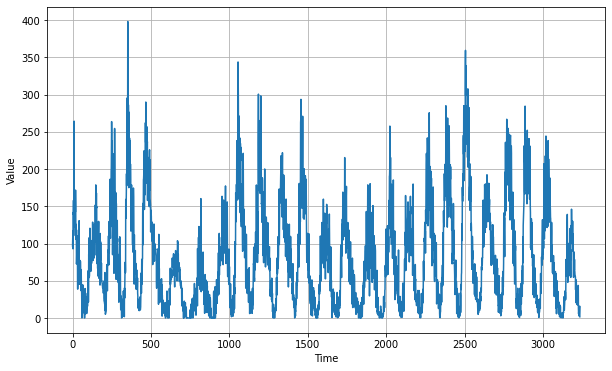

In [6]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

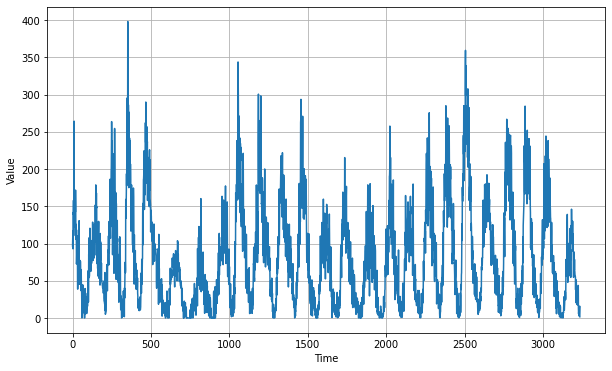

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 64ms/step - loss: 79.8343 - mae: 80.3317 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 78.0815 - mae: 78.5790 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 75.4648 - mae: 75.9626 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 16ms/step - loss: 72.2819 - mae: 72.7799 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 68.7799 - mae: 69.2777 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 65.1062 - mae: 65.6033 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 61.5307 - mae: 62.0276 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 17ms/step - loss: 58.1424 - mae: 58.6387 - l

(1e-08, 0.0001, 0.0, 60.0)

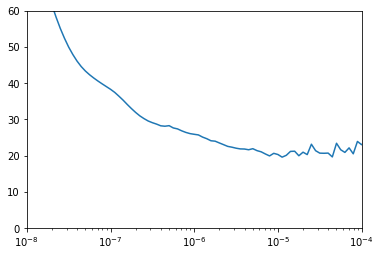

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 17ms/step - loss: 38.9158 - mae: 39.4122
Epoch 2/500
30/30 [==============================] - 0s 11ms/step - loss: 25.7669 - mae: 26.2614
Epoch 3/500
30/30 [==============================] - 0s 12ms/step - loss: 22.0837 - mae: 22.5774
Epoch 4/500
30/30 [==============================] - 0s 12ms/step - loss: 20.4680 - mae: 20.9610
Epoch 5/500
30/30 [==============================] - 0s 11ms/step - loss: 19.7201 - mae: 20.2124
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss: 19.3266 - mae: 19.8186
Epoch 7/500
30/30 [==============================] - 0s 11ms/step - loss: 18.6880 - mae: 19.1800
Epoch 8/500
30/30 [==============================] - 0s 11ms/step - loss: 18.2335 - mae: 18.7252
Epoch 9/500
30/30 [==============================] - 0s 11ms/step - loss: 18.0118 - mae: 18.5034
Epoch 10/500
30/30 [==============================] - 0s 12ms/step - loss: 17.8891 - mae: 18.3802
Epoch 11/500
30/30 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

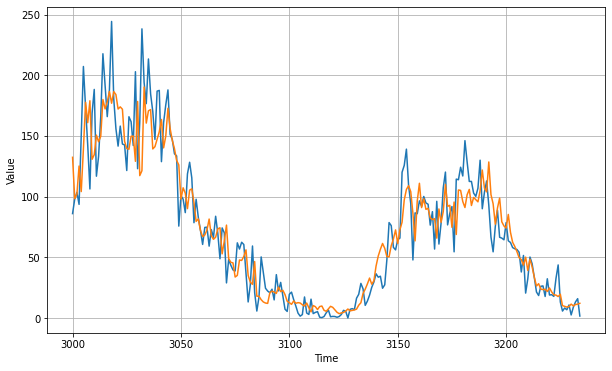

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.15922

<Figure size 432x288 with 0 Axes>

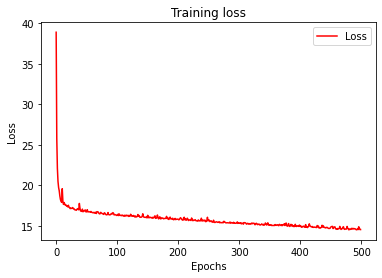

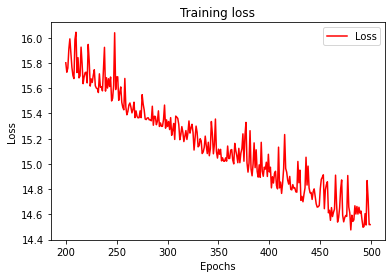

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[132.3798     98.3086    102.016136  125.17978   104.148544  139.18619
 177.70662   160.92471   178.96754   130.74611   134.49922   150.67366
 145.19394   149.64423   180.00183   172.24773   177.9236    186.64859
 176.92773   186.51001   184.03813   172.1831    173.93544   171.96811
 145.49855   139.66476   139.01076   149.66444   149.87941   129.06166
 178.3669    117.296776  121.33815   190.2951    160.5591    170.66714
 171.70071   139.2641    141.13062   147.36362   153.46863   163.55371
 140.14984   149.9571    172.77791   156.17654   146.30804   139.5031
 129.83325   126.08955    97.908005  107.25295   102.7849     90.08946
 105.31576   106.40039    95.10216    79.57119    81.62322    72.08656
  66.99214    68.3709     72.481155   81.50122    67.7714     64.81725
  66.57766    73.37964    74.34361    52.846233   63.37614    76.51643
  49.00464    45.86395    45.396484   33.72546    35.086555   47.795033
  47.38599    50.715916   56.11956    34.982037   29.538982   27.704031
  46.